In [30]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm

In [31]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

CPU times: user 511 ms, sys: 85.9 ms, total: 597 ms
Wall time: 1.77 s


(1099, 1)

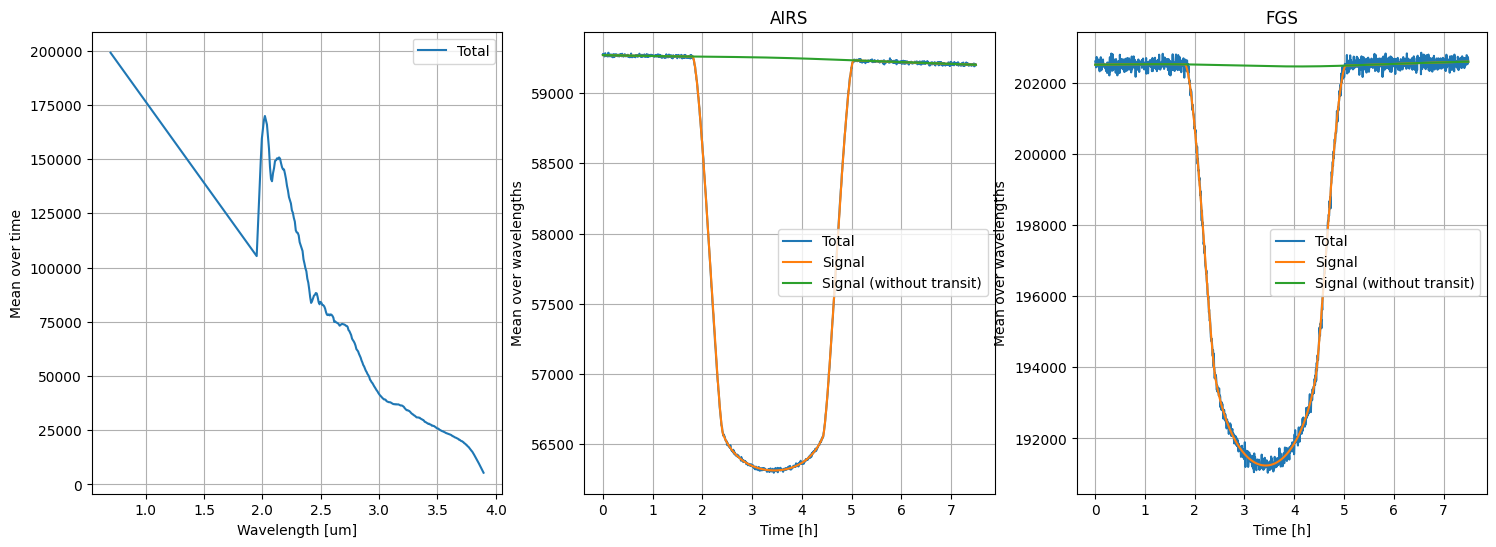

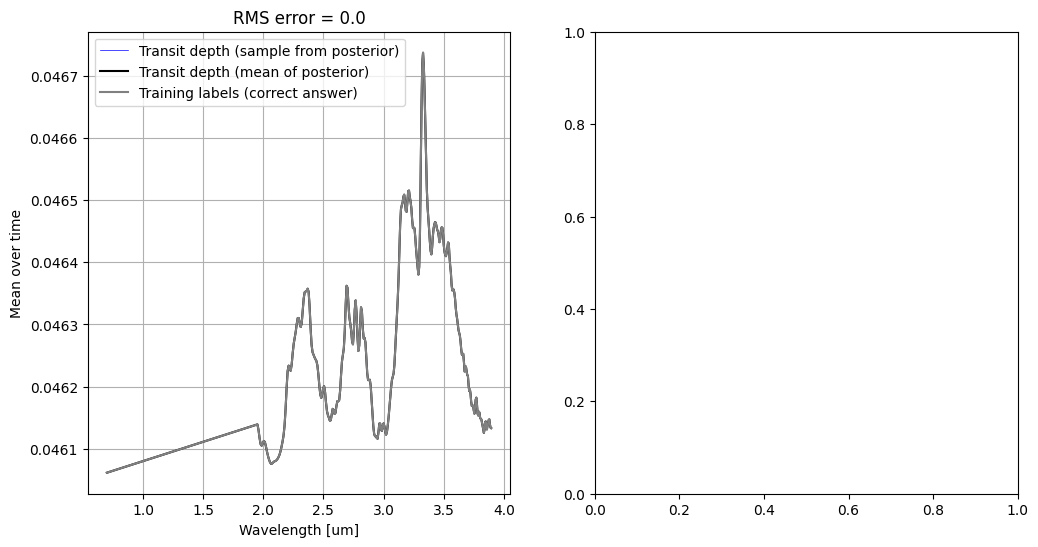

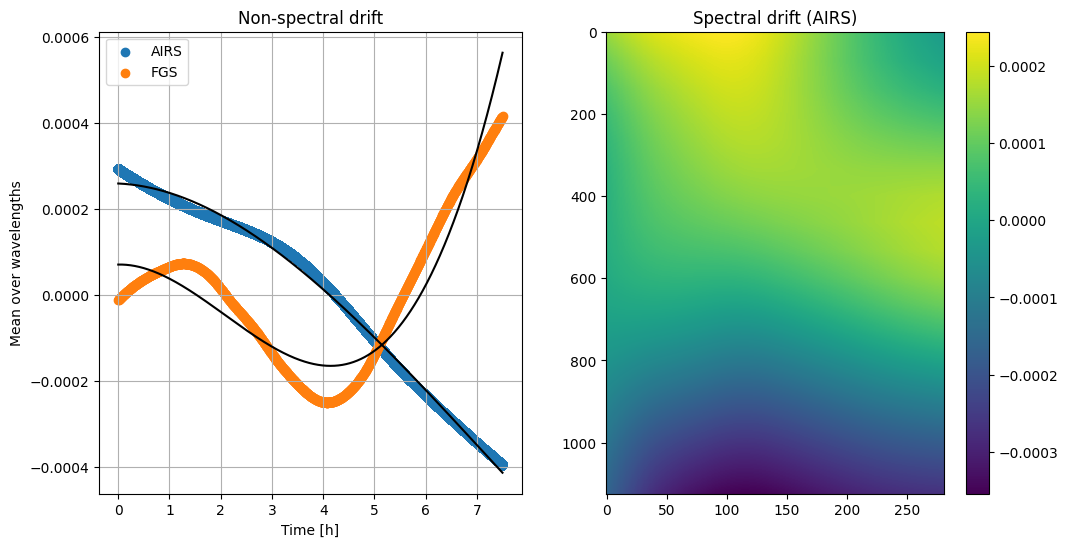

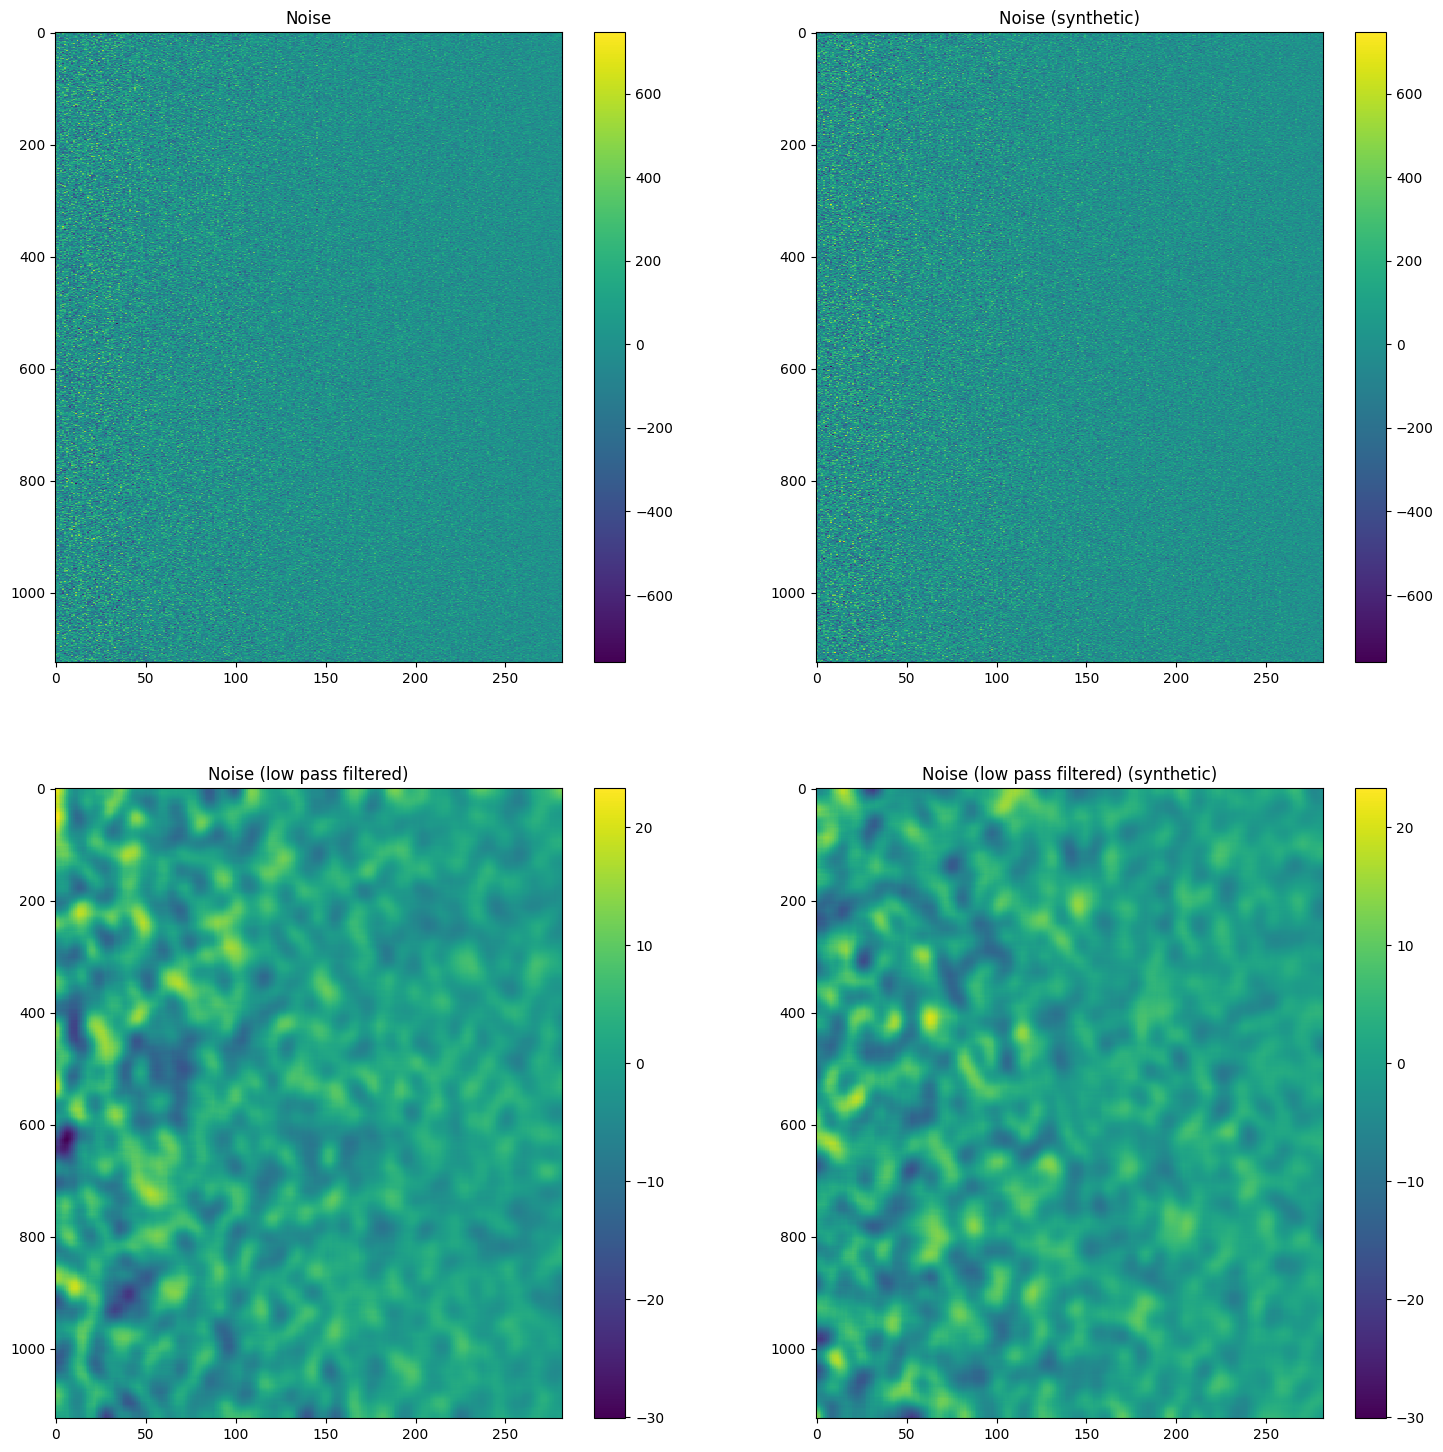

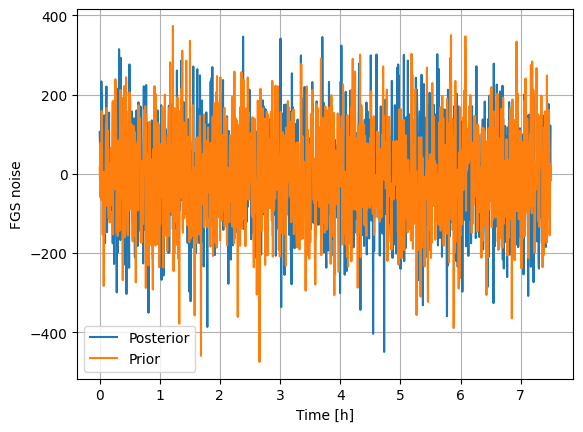

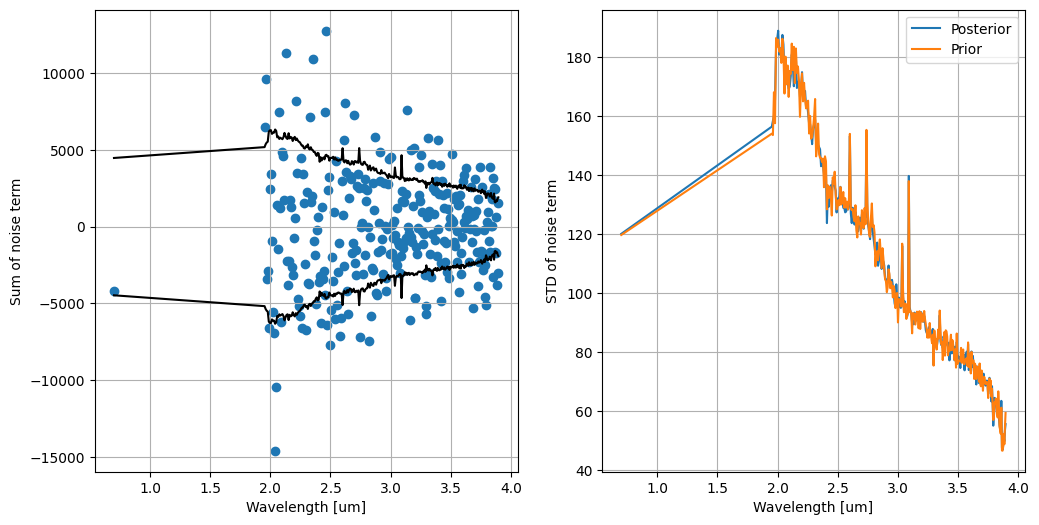

Score:          0.5732
RMS error FGS:  0.00 ppm
RMS error AIRS: 0.00 ppm
Score:          -0.2599
RMS error FGS:  236.62 ppm
RMS error AIRS: 224.28 ppm
CPU times: user 28.5 s, sys: 4.4 s, total: 32.9 s
Wall time: 33.3 s


(-0.2598857415545909, 0.00023661552068457437, 0.0002242797782776243)

In [45]:
%%time
import gp
import ariel_gp
kgs.profiling=False
kgs.debugging_mode=1
importlib.reload(gp)
importlib.reload(ariel_gp)
model = ariel_gp.PredictionModel()  
model.run_in_parallel=False
model.model_options.n_iter = 7
model.model_options.use_training_labels = True
model.starter_model.do_plots = False
model.plot_final = True
model.plot_simple = False
model.train(train_data)
#model.starter_model.loaders[0].cache_steps = [5]

for ii in range(2):                
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True                 
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
    model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
    model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
#model.loaders[1].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[1] = 1
model.loaders[0].cache_steps = [5]
model.starter_model.loaders = model.loaders
            
#model.loaders[0].cache_steps = [5]
data = train_data[2:3]
inferred_data = model.infer(data)
kgs.score_metric(inferred_data, data)
model.starter_model.do_plots = False
inferred_data_simple = model.starter_model.infer(data)
kgs.score_metric(inferred_data_simple, data)

In [44]:
model.results['model_mean'].m['signal'].m['transit'].AIRS_u_slopes

[[-0.019097811694279945, -0.05778101769661679]]

In [5]:
xx=np.std(model.results['model_samples'].m['signal'].m['transit'].get_parameters(),1)#/np.mean(model.results['model_samples'].m['signal'].m['transit'].get_parameters(),1))
plt.figure()
plt.plot(xx[:model.results['model_samples'].m['signal'].m['transit'].depth_model.number_of_parameters])
plt.figure()
plt.plot(xx[model.results['model_samples'].m['signal'].m['transit'].depth_model.number_of_parameters:])

TypeError: 'NoneType' object is not subscriptable

In [ ]:
val1 = [x[1].to_x()[1] for x in model.results['model_samples'].m['signal'].m['transit'].transit_params]
val2 = [x[1].to_x()[2] for x in model.results['model_samples'].m['signal'].m['transit'].transit_params]
plt.figure()
plt.scatter(val1,val2)
plt.figure()
plt.plot(np.array(val1)/np.array(val2))

In [ ]:
val1 = [x[0].i for x in model.results['model_samples'].m['signal'].m['transit'].transit_params]
val2 = [x[0].i for x in model.results['model_samples'].m['signal'].m['transit'].transit_params]
plt.figure()
plt.scatter(val1,val2)
plt.figure()
plt.plot(np.array(val1)/np.array(val2))

In [ ]:
import copy
print(model.results['model_samples'].m['signal'].m['transit'].transit_params[0][0])
val = [x[0].i for x in model.results['model_samples'].m['signal'].m['transit'].transit_params]
plt.figure()
plt.plot(val)
plt.figure()
for v in val:
    T = copy.deepcopy(model.results['model_samples'].m['signal'].m['transit'].transit_params[0][0])
    T.Rp = 0.1
    #xx = T.to_x()
    #xx[2] = v
    #T.from_x(xx)
    T.i=v
    plt.plot(T.light_curve(np.linspace(0,7,1000)))

In [ ]:
T=inferred_data[0].diagnostics['transit_params'][0]
T=model.results['model_mean'].m['signal'].m['transit'].transit_params[0][0]
T.Rp = 0.1
plt.plot(T.light_curve(np.linspace(0,7,10000)))
print(T)
#print(model.results['model_mean'].m['signal'].m['transit'].transit_params[0][0])

In [ ]:
import copy
plt.figure()
T = copy.deepcopy(model.results['model_samples'].m['signal'].m['transit'].transit_params[0][0])
T.Rp = 0.1
base_curve = T.light_curve(np.linspace(0,7,1000))
T = copy.deepcopy(model.results['model_samples'].m['signal'].m['transit'].transit_params[0][0])
T.Rp = 0.1
T.P += 1
mod_curve = T.light_curve(np.linspace(0,7,1000))
plt.plot(mod_curve-base_curve)
T = copy.deepcopy(model.results['model_samples'].m['signal'].m['transit'].transit_params[0][0])
T.Rp = 0.1
T.sma += -0.105
mod_curve2 = T.light_curve(np.linspace(0,7,1000))
plt.plot(mod_curve2-base_curve)
plt.figure()
plt.semilogy(1-(mod_curve2-base_curve)/(mod_curve-base_curve))